## Datasets

The FastAI datasets class contains the web URL fetch link for a wide collection of classic datasets (such as MNIST, ImageNet, etc) for computer vision, NLP, audio, etc. 

The entirety of the `Datasets` class is defined under `fastai_cust.datasets.py`, which is just a direct copy from the original fastai repo without any modification: https://github.com/fastai/fastai/blob/master/fastai/datasets.py. (Note: T\the `Datasets` class utilizes helper functions defined under `fastai_cust.core.py` which is also a direct copy from the original source.

The code snippet below shows how to utilize the `Datasets` class and quickly get started working with a curated dataset.

In [43]:
from fastai_cust import datasets
from fastai_cust.core import *

# lets grab the Imagenette dataset
datasets.URLs.IMAGENETTE_160

'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160'

In [2]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160); path

PosixPath('/root/.fastai/data/imagenette2-160')

let's examine the directories under `path`

In [3]:
path.ls()

[PosixPath('/root/.fastai/data/imagenette2-160/train'),
 PosixPath('/root/.fastai/data/imagenette2-160/val')]

In [4]:
(path/'val').ls()

[PosixPath('/root/.fastai/data/imagenette2-160/val/n03394916'),
 PosixPath('/root/.fastai/data/imagenette2-160/val/n02102040'),
 PosixPath('/root/.fastai/data/imagenette2-160/val/n03028079'),
 PosixPath('/root/.fastai/data/imagenette2-160/val/n03888257'),
 PosixPath('/root/.fastai/data/imagenette2-160/val/n03425413'),
 PosixPath('/root/.fastai/data/imagenette2-160/val/n03417042'),
 PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186'),
 PosixPath('/root/.fastai/data/imagenette2-160/val/n01440764'),
 PosixPath('/root/.fastai/data/imagenette2-160/val/n03445777'),
 PosixPath('/root/.fastai/data/imagenette2-160/val/n03000684')]

In [5]:
(path/'val'/'n03394916').ls()[:4]

[PosixPath('/root/.fastai/data/imagenette2-160/val/n03394916/n03394916_45202.JPEG'),
 PosixPath('/root/.fastai/data/imagenette2-160/val/n03394916/n03394916_8120.JPEG'),
 PosixPath('/root/.fastai/data/imagenette2-160/val/n03394916/n03394916_26391.JPEG'),
 PosixPath('/root/.fastai/data/imagenette2-160/val/n03394916/n03394916_27071.JPEG')]

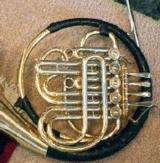

In [15]:
from PIL import Image

img_fn = (path/'val'/'n03394916').ls()[0]
img = PIL.Image.open(img_fn)
img

---
## ListContainer

The `ListContainer` is simply a wrapper function around "a list of items" contained under `self.items`. The remainder of the class simply provides custom index-based access method where the index can be integers or boolean flags. Other methods also include `get`, `set`, `del` and `iter`.

In [18]:
from typing import *

def listify(o):
    "Convert object into list type"
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]


def setify(o): 
    return o if isinstance(o,set) else set(listify(o))


class ListContainer():
    "Generic class around list of items with custom idx access methods"    
    def __init__(self, items): 
        self.items = listify(items)
        
    def __getitem__(self, idx):
        "__getitem__ method is called when class object indexing is used"
        # for integer or slice access pattern
        if isinstance(idx, (int,slice)): return self.items[idx]
        # for boolean mask access pattern (i.e. idx = [True, True, False, ...])
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        # for list access pattern
        return [self.items[i] for i in idx]
    
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
        
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [20]:
# test instantiate & __repre__
a = ListContainer(range(100)); a

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [21]:
# test access patterns
print(a[5]);
print(a[slice(5,10,2)])
print(a[[True, False, False, False, True]*20])
print(a[[2,5,8,30]])

5
[5, 7, 9]
[0, 4, 5, 9, 10, 14, 15, 19, 20, 24, 25, 29, 30, 34, 35, 39, 40, 44, 45, 49, 50, 54, 55, 59, 60, 64, 65, 69, 70, 74, 75, 79, 80, 84, 85, 89, 90, 94, 95, 99]
[2, 5, 8, 30]


In [22]:
# test __setitem__ 
a[2] = 'a'; a

ListContainer (100 items)
[0, 1, 'a', 3, 4, 5, 6, 7, 8, 9...]

In [23]:
# test __delitem__
del a[2]; a

ListContainer (99 items)
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10...]

---
## Get files

The `get_files` function will be used internally by the `ImageList.from_files`. The key here is that the `get_files` function uses `os.walk(path)` and `os.scandir(path)` (which are executing C code underneath the hood) to provide super fast directory traversal capabilities.

In [24]:
import os
from pathlib import *


def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res


def get_files(path, extensions=None, recurse=False, include=None):
    "Returns list of filepaths filtered by list of extensions"
    path = Path(path)
    # get list of unique extensions
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    if recurse:
        # recursively go through all files (f) under sub-directories (d) within path (p)
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)):
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        # get list of files in path
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)


In [39]:
# ex. usage of os.walk
test = [(p,d,f) for p,d,f in list(os.walk('.'))][0]
print(f'p:{test[0]}\nd:{test[1]}\nf:{test[2]}')

p:.
d:['fastai_cust', 'workbench', '.ipynb_checkpoints', '.git']
f:['.docker_temp_859930667', 'audit.avro', '2. PyTorch nn.Module.ipynb', '.DS_Store', '1. PyTorch Dataset & DataLoader.ipynb', 'Untitled.ipynb', '3. FastAI Databunch & Learner (basic training loop).ipynb', '6. FastAI Runner.ipynb', '0. Journey to Keimin Initialiization.ipynb', '5. FastAI Callbacks.ipynb', 'README.md', '8. FastAI Datasets & ItemLists & Datablock.ipynb', '7. FastAI Callback Samples.ipynb', '.gitignore', '4. Callbacks.ipynb']


In [40]:
# ex. get all files with .ipynb within the current directory
get_files('.', extensions=['.ipynb'])

[PosixPath('2. PyTorch nn.Module.ipynb'),
 PosixPath('1. PyTorch Dataset & DataLoader.ipynb'),
 PosixPath('Untitled.ipynb'),
 PosixPath('3. FastAI Databunch & Learner (basic training loop).ipynb'),
 PosixPath('6. FastAI Runner.ipynb'),
 PosixPath('0. Journey to Keimin Initialiization.ipynb'),
 PosixPath('5. FastAI Callbacks.ipynb'),
 PosixPath('8. FastAI Datasets & ItemLists & Datablock.ipynb'),
 PosixPath('7. FastAI Callback Samples.ipynb'),
 PosixPath('4. Callbacks.ipynb')]

---
### ItemList

The `ItemList` class is yet another wrapper on top of the `ListContainer` class. In addition, it holds all the `transform` objects to be applied on top of each data items inside the class object. These transformations are done via a series of `compose` function calls to sequentially transform the data in pre-defined order (via the `_order` value inside each `tfms` function.


In [68]:
def compose(x, funcs, *args, order_key='_order', **kwargs):
    """
    Generic composition function where the output is the result
    of input `x` after applying a series of ordered functions 
    `funcs` on top of it. `order_key` can be used to sort the 
    order that funcs are applied to `x`.
    """
    key = lambda o: getattr(o, order_key, 0)
    for f in sorted(listify(funcs), key=key): 
        x = f(x, **kwargs)
    return x


class ItemList(ListContainer):
    """
    Wrapper on top of the `ListContainer` class and list of transform functions
    (self.tfms) that get applied each & every one of the items in self.items.
    """
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items) # pass items to super class
        self.path, self.tfms = Path(path), tfms

    def __repr__(self): 
        return f'{super().__repr__()}\nPath: {self.path}'
    
    def new(self, items, cls=None):
        if cls is None: cls=self.__class__
        return cls(items, self.path, tfms=self.tfms)
    
    def  get(self, i): return i
    
    def _get(self, i): 
        "Returns `items[i]` and uses the composition to apply a series of transformation."
        return compose(self.get(i), self.tfms)
    
    def __getitem__(self, idx):
        """
        Returns item(s) based on idx acess, then applies transformation composition on 
        each item via the `_get` method 
        """
        res = super().__getitem__(idx)
        if isinstance(res,list): return [self._get(o) for o in res]
        return self._get(res)

ERROR! Session/line number was not unique in database. History logging moved to new session 8


In [69]:
# ex. creating itemlist
items = get_files('.', extensions=['.ipynb'])
il = ItemList(items)

# get method
print(il[3])  # direct index access
print(il[2:5]) # range access
print(il[slice(0,10,3)])  # slice access

3. FastAI Databunch & Learner (basic training loop).ipynb
[PosixPath('Untitled.ipynb'), PosixPath('3. FastAI Databunch & Learner (basic training loop).ipynb'), PosixPath('6. FastAI Runner.ipynb')]
[PosixPath('2. PyTorch nn.Module.ipynb'), PosixPath('3. FastAI Databunch & Learner (basic training loop).ipynb'), PosixPath('5. FastAI Callbacks.ipynb'), PosixPath('4. Callbacks.ipynb')]


---
### ImageList

The `ImageList` is yet another wrapper on top of the ItemList, specific to image-based datasets.

In [70]:
class ImageList(ItemList):
    """
    Inherits from ItemList but specific to dataset composed of images. 
    More specifically, class instantiation is done directly via the `from_files` class method, which
    fetch all image file names under `path` and passes all parameters to `ItemList.__init__` for 
    class object instantiation. To allow total flexibility, ImageList returns the raw PIL image.
    """
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        ""
        if extensions is None:
            extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn):
        return PIL.Image.open(fn) # simply opens image file based on filename

In [71]:
class Transform(): _order=0

class MakeRGB(Transform):
    def __call__(self, item): 
      return item.convert('RGB')

def make_rgb(item):
  return item.convert('RGB')

In [87]:
# instantiate ImageList with callback class objects...
cb_rgb = MakeRGB()
il = ImageList.from_files(path, tfms=[cb_rgb])

# or... instantiate ImageList with simple pass-through function
il2 = ImageList.from_files(path, tfms=[make_rgb])

In [92]:
print(il); print('\n', il2)

ImageList (13394 items)
[PosixPath('/root/.fastai/data/imagenette2-160/train/n03394916/n03394916_18048.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n03394916/n03394916_39153.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n03394916/n03394916_22455.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n03394916/n03394916_23434.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n03394916/n03394916_35076.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n03394916/n03394916_14327.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n03394916/n03394916_37438.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n03394916/n03394916_44724.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n03394916/n03394916_30036.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n03394916/n03394916_36308.JPEG')...]
Path: /root/.fastai/data/imagenette2-160

 ImageList (13394 items)
[PosixPath('/root/.fastai/data/imagenette2-16

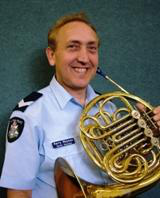

In [94]:
il[10]

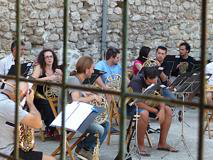

In [95]:
il2[11]